# A/B-тестирование

### Цель проекта:
Провести оценку результатов A/B-теста. В распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.


### Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## Загрузка и первичный анализ данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
import numpy as np
from scipy import stats as st

In [2]:
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
display(marketing_events)
marketing_events.info()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [3]:
# Изменим тип для столбцов с датами
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])


In [4]:
events = pd.read_csv('/datasets/final_ab_events.csv')
display(events)
events.info()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


Видим, что в столбце details  большая часть данных - пропуски. Эти пропуски могут быть связаны с тем, что рассматироваемый тип события не имеет какой-то дополнительной информации. Оставим эти пропуски, в дальнейшем этот стобец не планируем использовать 

In [5]:
# посмотрим уникальные значения для event_name
events.event_name.unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [6]:
# Изменим тип для столбцов с датами
events['event_dt'] = pd.to_datetime(events['event_dt'])

In [7]:
# проверим дубликаты 
events.duplicated().sum()

0

In [8]:
new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
display(new_users)
new_users.info()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [9]:
# посмотрим уникальные значения для region

new_users.region.unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [10]:
# посмотрим уникальные значения для device

new_users.device.unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

In [11]:
# Изменим тип для столбцов с датами
new_users.first_date = pd.to_datetime(new_users.first_date)

In [12]:
# проверим дубликаты 
new_users.duplicated().sum()

0

In [13]:
participants = pd.read_csv('/datasets/final_ab_participants.csv')
display(participants)
participants.info()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [14]:
# проверим дубликаты
participants.duplicated().sum()

0

**Выводы:**
- данные загружены
- явных строк-дубликатов в датасетах не обнаружно, в уникальных значений категориальных столбцов неявных дубликатов не обнаружено
- типы данных приведены к нужным
- в таблице events  в столбце details  большая часть данных - пропуски. Эти пропуски могут быть связаны с тем, что рассматироваемый тип события не имеет какой-то дополнительной информации. Оставили эти пропуски, в дальнейшем этот стобец не планируем использовать 

## Оценка корректности проведения теста

In [15]:
participants.ab_test.unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Видим, что в таблице участников есть информация по двум тестам: recommender_system_test и interface_eu_test. Нас же интересует recommender_system_test 

In [16]:
participants.query('ab_test == "recommender_system_test"').group.unique()

array(['A', 'B'], dtype=object)

Для recommender_system_test есть две группы: А и В, это соответствует техзаданию.

In [17]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [18]:
print('Минимальная дата (дата запуска):',events.event_dt.dt.date.min())
print('Максимальная дата (дата остановки):',events.event_dt.dt.date.max())

Минимальная дата (дата запуска): 2020-12-07
Максимальная дата (дата остановки): 2020-12-30


Видим, что дата запуска соответсвует критериям техзадания. **Дата остановки не соотвествует** - тест закончился 2020-12-30, хотя в техзадании говорится про 2021-01-04. Так как тест закончился на 5 дней раньше - последние зарегистрированные пользователи провели в приложении меньше 14 дней - что также противоречит условиям ТЗ

In [19]:
# создадим множество пользователей - участников recommender_system_test
recsys_participants = set(participants.query('ab_test == "recommender_system_test"').user_id.unique())
# создадим соответствующий датафрейм 
new_users_recsys = new_users.query('user_id in @recsys_participants')

In [20]:
print('Дата начала набора новых пользователей:',new_users_recsys.first_date.min())
print('Дата окончания набора новых пользователей:',new_users_recsys.first_date.max())

Дата начала набора новых пользователей: 2020-12-07 00:00:00
Дата окончания набора новых пользователей: 2020-12-21 00:00:00


Дата окончания набора новых пользователей  **соответствует** требованию техзадания. Набор продолжался до 21 декабря, что соответствует ТЗ. 

In [21]:
# посчитаем долю юзеров из EU, попадающих в нужный тест относительно общего количества юзеров из  EU
round(new_users_recsys.query('region == "EU" ').user_id.count() / \
    new_users.query('region == "EU"').user_id.count(),2)


0.14

Здесь все почти соотвествует техзаданию. Аудитория теста - 14% новых пользователей из региона EU

In [22]:
new_users_recsys.region.value_counts()

EU           6351
N.America     223
APAC           72
CIS            55
Name: region, dtype: int64

Видим, что из новых пользователей участников recommender_system_test есть помимо EU встречаются другие регионы

In [23]:
new_users_recsys.query('region == "EU"').user_id.count()

6351

Количество участников несколько выше, чем в требовании ТЗ, но не критично. 

In [24]:
start_date = events.event_dt.dt.date.min()
end_date = events.event_dt.dt.date.max()

In [25]:
# Убедимся, что время проведения теста не не совпадает с маркетинговыми активностями, проводимыми в регионе EU
marketing_events.query('''

        regions.str.contains("EU") and\
        (start_dt<@start_date and finish_dt>@end_date or\
        start_dt>@start_date and start_dt<@end_date and finish_dt>@end_date or\
        start_dt<@start_date and finish_dt > @start_date and  finish_dt<@end_date )

                        ''' )

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Здесь видим, что маркетинговая кампания "Christmas&New Year Promo" началась за 5 дней до даты остановки теста. Проведение данной акции может влиять на результаты проводимого А/В теста и, соотсетственно, привести к неправильным выводам. 

Проверим аудиторию теста. Удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверим равномерность распределения по тестовым группам и правильность их формирования.

In [26]:
# Для удобства объеденим датасет с участниками тестирования с датасетом новых пользователей.
# Будем использовать inner join. Таким образом, останутся только те участники, которые есть в таблице с новыми пользователями
participants = participants.merge(new_users, on='user_id')
# Также обросим пользователей не из региона EU
participants = participants.query('region == "EU"')

In [27]:
# посмотрим сколько пользователей принимали участие в двух тестах
participants.ab_test.value_counts()

interface_eu_test          11567
recommender_system_test     6351
Name: ab_test, dtype: int64

In [28]:
print('Количесво пользователей, учавcтсвующих одновременно в двух тестах:',
      len(set(participants.query('ab_test == "recommender_system_test"'
                                    )['user_id']) & set(participants.query('ab_test == "interface_eu_test"')['user_id'])
          )
      )


Количесво пользователей, учавcтсвующих одновременно в двух тестах: 1602


Видим, что у нас есть пользователи, которые одновременно участвуют в двух разных А/В тестах - это может привести к некорректным результатам, поскольку мы не знаем изменения какого из тестов повлияли на поведение пользователей. Для получения независимых результатов тестирования и корректных выводов отбросим пользователей recommender_system_test, которые попадают в группу В (группа с изменением) конкурирующего теста.

In [29]:
good_set = (set(participants.query('ab_test == "recommender_system_test"'
                                   )['user_id']) - set(participants.query('ab_test == "interface_eu_test" and group == "B"')['user_id']))
participants_recsys = participants.query(
    "user_id in @good_set and ab_test == 'recommender_system_test'").reset_index(drop=True)


In [30]:
participants_recsys.shape

(5568, 6)

Оставили в итоговом датафрейме только 5568 независимых пользователей, что несколько меньше требованиям ТЗ

In [31]:
# Проверим, нет ли у нас пользователей, участвующих в двух группах теста одновременно
print('Количесво пользователей, учавтсвующих одновременно в двух тестах:',
      len(set(participants_recsys.query('group == "A"')['user_id']) & set(participants_recsys.query('group == "B"')['user_id'])
          )
      )


Количесво пользователей, учавтсвующих одновременно в двух тестах: 0


Здесь все хорошо, группы А и В не пересекаются

Количество участников несколько выше, чем в требовании ТЗ, но не критично. 

In [32]:
# посмотрим сколько пользователей в каждой из групп
participants_recsys.group.value_counts()


A    3195
B    2373
Name: group, dtype: int64

В группе А пользователей больше чем в группе В - это не совсем правильно. Такая несбалансированность может сказаться при сравнении количества действий пользователей. Однако, на оценку таких относительнх метрик как конверсия несбалансированнсть групп не должна повлиять 

**Выводы**:
- Видим, что дата запуска соответсвует критериям ТЗ. **Дата остановки не соотвествует** - тест закончился 2020-12-30, хотя в техзадании говорится про 2021-01-04
- Дата окончания набора новых пользователей  **соответствует** требованию техзадания. 
- Аудитория теста - 14% новых пользователей из региона EU
- Маркетинговая кампания "Christmas&New Year Promo" началась за 5 дней до даты остановки теста. Проведение данной акции может влиять на результаты проводимого А/В теста и, соотсетственно, привести к неправильным выводам. Будем аккуратны с действиями полозователей в последнии 5 дней теста.
- Есть пользователи, которые одновременно участвуют в двух разных А/В тестах - это может привести к некорректным результатам, поскольку мы не знаем изменения какого из тестов повлияли на поведение пользователей. Для получения независимых результатов тестирования и корректных выводов отбросили пользователей recommender_system_test, которые попадают в группу В (группа с изменением) конкурирующего теста.
- Оставили в итоговом датафрейме только 5568 независимых пользователей
- Для теста recommender_system_test нет пользователей, участвующих в двух группах теста одновременно
- В группе А содержится 3195 пользователей, в группе В 2373


### Исследовательский анализ данных

Посмотрим как количество событий на пользователя распределены в выборках А/В теста 

In [33]:
# создадим датафрейм с событиями, которые совершали интересующие нас пользователи из теста recommender_system_test
events_recsys = events.query('user_id in @good_set').reset_index(drop=True)
# создадим столбец дат
events_recsys['date'] = events_recsys['event_dt'].dt.date

# добавим столбец с группами А и В
events_recsys = events_recsys.merge(
    participants_recsys[['user_id', 'group']], on='user_id')


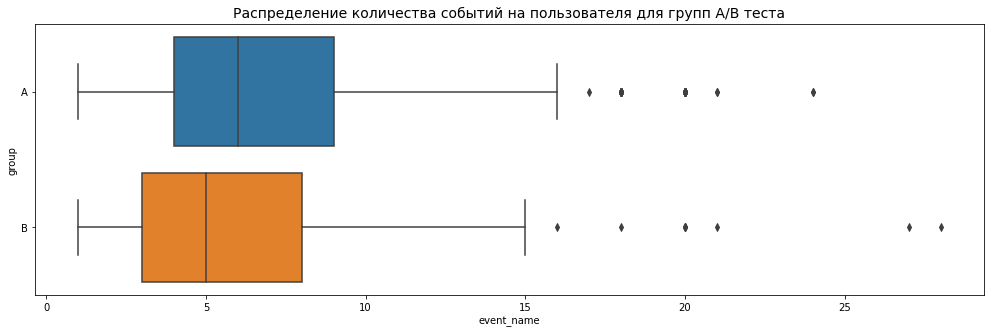

In [34]:
# Построим бокс-плоты количества событий на пользователя для соответствующих групп
plt.figure(figsize=(17, 5))

sns.boxplot(y="group", x="event_name",  data=events_recsys.groupby(
    ['user_id', 'group'], as_index=False).event_name.count())

plt.title(
    'Распределение количества событий на пользователя для групп A/B теста', fontsize=14);


Видим, что количество событий на пользователя распределены несколько по-разному в выборках А/В теста. Пользователи группы А совершают в среднем 7 событий, пользователи группы B в среднем совершают 5 событий. В целом распредения для группы В смещены в область низких значений количества событий

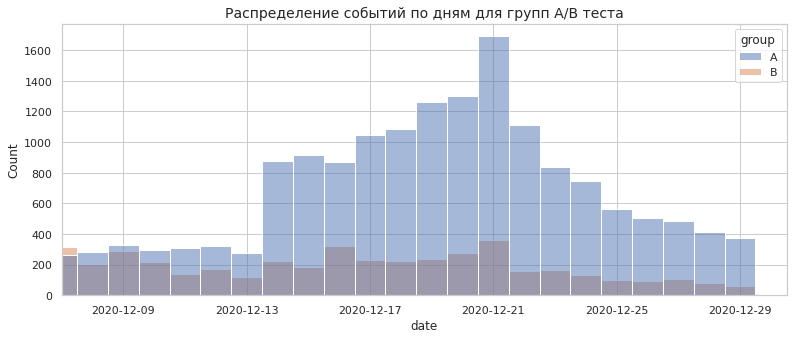

In [35]:
# Посмотрим на распределения пользовательских событий по датам 

sns.set_theme(style="whitegrid")

plt.figure(figsize=(13, 5))

sns.histplot(data=events_recsys,
             x='date', 
             hue='group'  
             )
plt.xlim(events_recsys['date'].min(), events_recsys['event_dt'].max())
plt.title('Распределение событий по дням для групп A/B теста', fontsize=14);


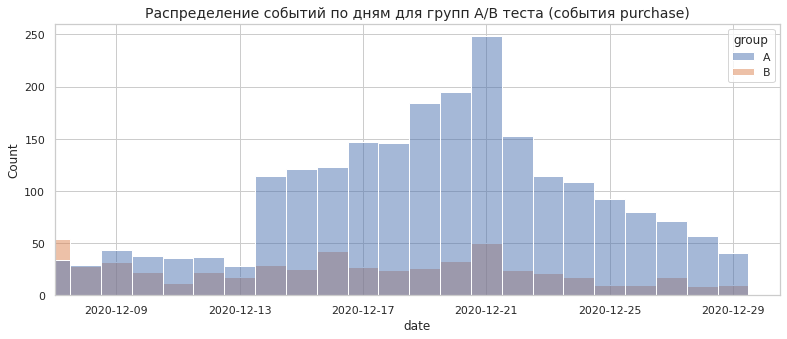

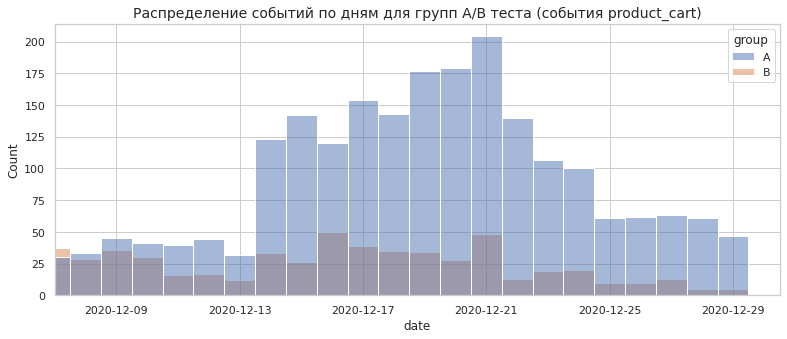

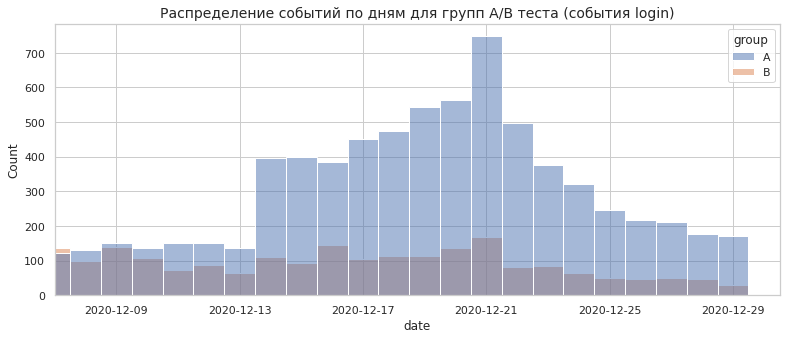

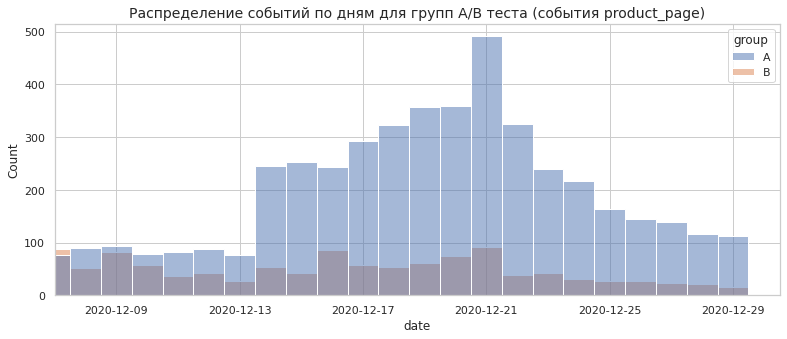

In [36]:
# Также посмотрим распределения по датам  с разбивкой по типу события
for ev in events_recsys.event_name.unique():
    plt.figure(figsize=(13, 5))

    sns.histplot(data=events_recsys.query('event_name == @ev'),
             x='date', 
             hue='group'  
             )

    plt.xlim(events_recsys['date'].min(), events_recsys['event_dt'].max())
    plt.title(f'Распределение событий по дням для групп A/B теста (события {ev})', fontsize=14);

    plt.show()

В распределении по дням пользователи двух групп также ведут себя по разному: пользователи группы В совершают меньше событий. Видим, что в начале теста активность пользователей находится на одном уровне, однако после 13 декабря активность пользователей группы А резко возрастает. После 21 декабря и до конца теста активность двух групп начинает снижаться. В последние 5 дней теста (когда начали маркетинговую кампанию "Christmas&New Year Promo") не отмечается каких-то явных изменений пользовательской активности

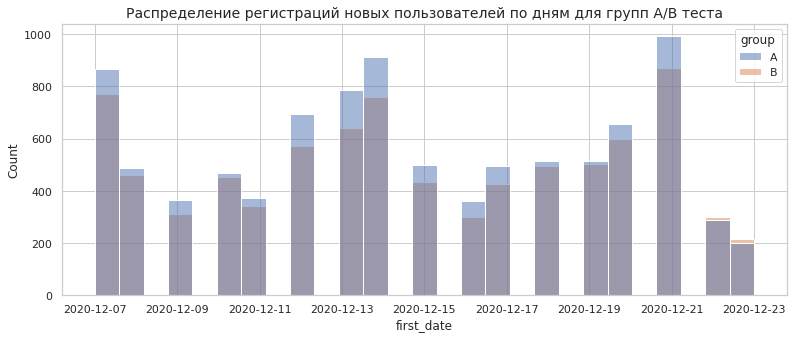

In [37]:
# Посмотрим на распределения регистраций новых пользователей по датам 

sns.set_theme(style="whitegrid")

plt.figure(figsize=(13, 5))

sns.histplot(data=participants,
             x='first_date', 
             hue='group'  
             )
plt.title('Распределение регистраций новых пользователей по дням для групп A/B теста', fontsize=14);


Здесь видим, что регистрации новых пользователей распределены по дням похоже. Видим, что на 21 декабря приходится максимальное количество новых пользователей - с этим скорее всего связан пик пользовательской активности на графиках с распределением событий по дням

### Конверсия

Поссмотрим как меняется конверсия в воронке в выборках на разных этапах.
Согласно ТЗ, ожидаемый эффект: пользователи покажут улучшение конверсии в просмотр карточек товаров, просмотры корзины и покупки не менее, чем на 10%


In [38]:
# Посчитаем конверсию в целевые действия для двух групп 
print('Конверсия для группы А:')
display(round((events_recsys.query('group=="A"').groupby('event_name').user_id.nunique() /
      participants_recsys.query('group=="A"').user_id.nunique()*100), 2).sort_values(ascending=False).to_frame())

print('Конверсия для группы B:')
round((events_recsys.query('group=="B"').groupby('event_name').user_id.nunique() /
      participants_recsys.query('group=="B"').user_id.nunique()*100), 2).sort_values(ascending=False).to_frame()



Конверсия для группы А:


,user_id
event_name,
login,71.33
product_page,46.20
purchase,22.97
product_cart,21.47


Конверсия для группы B:


,user_id
event_name,
login,32.49
product_page,18.08
purchase,9.23
product_cart,9.02


Видим, общая конверсия пользователей для группы существенно B ниже чем в группе А. 

Также, довольно странно, что конверсия в покупку несколько выше, чем конверсия в просмотр корзины.

Для группы А: 
- 46% участников совершают просмотр карточек товаров 
- 22% участников просматривают корзину
- 23% участников делают покупку

Для группы В: 
- 18% участников совершают просмотр карточек товаров 
- 9% участников просматривают корзину
- 9% участников делают покупку

Заявленное в ТЗ увеличения метрик на 10% не наблюдается - скорее наоборот.

Напрашиавется **вывод**, о том, что введение новой рекомендательной системы негативно сказывается на конверсии пользователей.

### Результаты A/B-тестирования

Необходимо отметить, что множество пунктов из ТЗ и критериев корректности А/В эксперимента в нашем случае не были корректно учтены: 
- **Дата остановки не соотвествует требованиям ТЗ** - тест закончился 2020-12-30, хотя в техзадании говорится про 2021-01-04. Так как тест закончился на 5 дней раньше - последние зарегистрированные пользователи провели в приложении меньше 14 дней - что противоречит условиям ТЗ
- Дата окончания набора новых пользователей  **не соответствует** требованию техзадания. Набор продолжался до 23 декабря, а в техзадании говорится о 21 декабря. 
- **Маркетинговая кампания "Christmas&New Year Promo" началась за 5 дней** до даты остановки теста. Проведение данной акции может влиять на результаты проводимого А/В теста и, соотсетственно, привести к неправильным выводам. 
- Есть **пользователи**, которые **одновременно участвуют в двух разных А/В тестах** - это может привести к некорректным результатам, поскольку мы не знаем изменения какого из тестов повлияли на поведение пользователей. Для получения независимых результатов тестирования и корректных выводов были вынуждены отбросить пользователей recommender_system_test, которые попадают в группу В (группа с изменением) конкурирующего теста.
- Группы А и В **несбалансированны**, что также является критерием неправильного проведения эксперимента
- Как показал исследовательский анализ данных, конверсии в просмотр карточек товаров, просмотры корзины и покупки для группы с новой рекомендательной системой существенно ниже, чем у контрольной группы без изменений. Хотя изначально план ТЗ предполагал, что конверсии должны улучшиться не менее чем на 10% относительно контрольной группы. На деле **видим ухдшение метрик на 50%** и более.

**В общем данный тест нельзя назвать корректно проведенным**



#### Наконец, проверим статистическую разницу долей z-критерием.

In [39]:
# напишем функцию для выполнения z-теста
def z_test(df, df2, ev, g_1, g_2):

    alpha = 0.05 # критический уровень статистической значимости

    event = np.array([df.query('event_name == @ev & group == @g_1').user_id.nunique(), 
                            df.query('event_name == @ev & group == @g_2').user_id.nunique()])

    all_events = np.array([df2.query('group == @g_1').user_id.nunique(),
                        df2.query('group == @g_2').user_id.nunique() ])

    # пропорция в первой группе:
    p1 = event[0]/all_events[0]

    # пропорция во второй группе:
    p2 = event[1]/all_events[1]

    # пропорция в комбинированном датасете:
    p_combined = (event[0] + event[1]) / (all_events[0] + all_events[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / np.sqrt(
        p_combined * (1 - p_combined) * (1 / all_events[0] + 1 / all_events[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Результаты статистического теста для групп {}, {}, и события {}:'.format(g_1,g_2, ev))
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница\n')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными\n'
        ) 
 


In [40]:
# запустим z-тест по каждому из событий для контрольных групп А/B теста
for event in ['purchase', 'product_cart', 'product_page']:
    z_test(events_recsys,participants_recsys, event, 'A', 'B')

Результаты статистического теста для групп A, B, и события purchase:
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница

Результаты статистического теста для групп A, B, и события product_cart:
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница

Результаты статистического теста для групп A, B, и события product_page:
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница



**Вывод:** Различия между значениями группы A и В в конкретном случае являются существенными. Это подтверждает результаты исследовательского анализа по конверсии - введение новой рекомендательной системы негативно сказывается конверсии в целевые действия. Гипотеза о росте метрик  на 10% за счет внедрения рекомендательной системы на имеющихся данных не подтвердилась.

## Общий вывод

В рамках проекта были проведена оценка результатов A/B-теста. Было показано, что что множество пунктов из ТЗ и критериев корректности А/В эксперимента в нашем случае не были корректно учтены: 
- **Дата остановки не соотвествует требованиям ТЗ** - тест закончился 2020-12-30, хотя в техзадании говорится про 2021-01-04. Так как тест закончился на 5 дней раньше - последние зарегистрированные пользователи провели в приложении меньше 14 дней - что противоречит условиям ТЗ
- **Маркетинговая кампания "Christmas&New Year Promo" началась за 5 дней** до даты остановки теста. Проведение данной акции может влиять на результаты проводимого А/В теста и, соотсетственно, привести к неправильным выводам. 
- Есть **пользователи**, которые **одновременно участвуют в двух разных А/В тестах** - это может привести к некорректным результатам, поскольку мы не знаем изменения какого из тестов повлияли на поведение пользователей. Для получения независимых результатов тестирования и корректных выводов были вынуждены отбросить пользователей recommender_system_test, которые попадают в группу В (группа с изменением) конкурирующего теста.
- Группы А и В **несбалансированны**, что также является критерием неправильного проведения эксперимента


Учитывая требования ТЗ и формальные критерии корректности А/В экспериментов, данный тест нельзя назвать корректно проведенным. 

Исследовательский анализ показал, что количество событий на пользователя распределены несколько по-разному в выборках А/В теста. Пользователи группы А совершают в среднем 7 событий, пользователи группы B в среднем совершают 5 событий. В целом распредения для группы В смещены в область низких значений количества событий.
В распределении по дням пользователи двух групп также ведут себя по разному: пользователи группы В совершают меньше событий. Видим, что в начале теста активность пользователей находится на одном уровне, однако после 13 декабря активность пользователей группы А резко возрастает. После 21 декабря и до конца теста активность двух групп начинает снижаться. В последние 5 дней теста (когда начали маркетинговую кампанию "Christmas&New Year Promo") не отмечается каких-то явных изменений пользовательской активности. Конверсии в просмотр карточек товаров, просмотры корзины и покупки для группы с новой рекомендательной системой существенно ниже, чем у контрольной группы без изменений. Хотя изначально план ТЗ предполагал, что конверсии должны улучшиться не менее чем на 10% относительно контрольной группы. На деле **видим ухдшение метрик на 50%** и более.

Результат статистического z-теста показал, что различия между значениями группы A и В в конкретном случае являются существенными. Это подтверждает результаты анализа по конверсии - введение новой рекомендательной системы негативно сказывается конверсии в целевые действия. Гипотеза о росте метрик  на 10% за счет внедрения рекомендательной системы на имеющихся данных не подтвердилась.

### Рекомендации:
Чтобы окончательно убедиться в адекватности результатов, **рекомендуется** провести тест повторно с учетом всех пунктов ТЗ и формальных критериев правильности А/В экспериментов. Также, при проведени нового эксперимента следует выбрать более подходящее и спокойной время, чем канун нового года. Перед проведением рекомендуется убедиться в отсутствии планов на проведение маркетинговых событий во время теста.
